# Supervised Learning — Model Quality

## 📌 Project Goal
Build a model that predicts the probability of a **decrease in a customer’s activity** and identify segments for personalized marketing offers.
GitHub repository: https://github.com/alexkeram/mini-etl-dbt-prefect

---

## 🔹 Step 1. Data Loading

- Load all provided files:
  - `market_file.csv`
  - `market_money.csv`
  - `market_time.csv`
  - `money.csv`
- Verify that the data matches the documentation.
- Double-check delimiters and numeric parsing (notably `sep=';'` and `decimal=','`).

---

## 🔹 Step 2. Data Preprocessing

- Inspect dtypes, missing values, and duplicates.
- Convert numeric features to proper numeric types (e.g., `object → float`).
- Drop or impute missing values where appropriate.
- Perform initial cleaning and recode categorical values if needed.

---

## 🔹 Step 3. Exploratory Data Analysis (EDA)

- Visualize and describe features:
  - distributions,
  - outliers,
  - unique values for categorical features.
- Identify customers with at least one purchase in the last 3 months.
- Examine the distribution of the target (`customer_activity`, focusing on the class “decreased”).
- Detect potential correlations and anomalies.

---

## 🔹 Step 4. Merging Tables

- Join tables by `id`, reshaping the period tables to a **wide** format:
  - From `market_money.csv` build: `revenue_current`, `revenue_prev`, `revenue_prev_prev`.
  - From `market_time.csv` build: `time_current`, `time_prev`, `time_prev_prev`.
- Join these to `market_file.csv`.
- Keep `money.csv` (profit) separate for later segmentation.

---

## 🔹 Step 5. Correlation Analysis

- Compute a correlation matrix for numeric features.
- Visualize a heatmap.
- If necessary, remove one of the strongly correlated features (to mitigate multicollinearity).

---

## 🔹 Step 6. Modeling with Pipelines

### 6.1 Pipeline Preparation

- Use `ColumnTransformer` for separate preprocessing:
  - Categorical: `OneHotEncoder` (or `OrdinalEncoder` where order is known).
  - Numeric: `StandardScaler` (or `MinMaxScaler` as needed).
- Assemble the end-to-end workflow with `Pipeline`.

### 6.2 Model Training

Train and tune the following models:
- `LogisticRegression`
- `DecisionTreeClassifier`
- `KNeighborsClassifier`
- `SVC`

### 6.3 Metric Selection

- Primary metric: **ROC AUC** (binary classification with potential class imbalance).
- Use `RandomizedSearchCV` or `GridSearchCV` with cross-validation.

---

## 🔹 Step 7. Model Interpretation

- Select the best model by ROC AUC.
- Estimate feature importance for the winner.
- Use `SHAP` to visualize global/individual feature effects.
- Summarize:
  - which features have the largest impact;
  - which ones can be dropped;
  - business interpretation of the results.

---

## 🔹 Step 8. Customer Segmentation & Recommendations

### 8.1 Segmentation

- Combine model outputs (probability of **decreased** activity) with `money.csv`.
- Create 2–3 segments by:
  - profit,
  - share of promo purchases,
  - product category,
  - probability of decreased activity.

### 8.2 Segment Analysis

- Visualize distributions and key features for the chosen segment.
- Describe business characteristics.
- Propose retention actions:
  - newsletter policy tweaks,
  - new promotions,
  - personalized offers.

### 8.3 Segment Conclusions

- Which segment is selected.
- What actions are proposed.
- Why this matters for the business.

---

## 🔹 Step 9. Overall Summary

- Briefly cover:
  - the task,
  - raw data & sources,
  - preprocessing steps,
  - model training & results,
  - the selected model & metric,
  - feature interpretation,
  - segmentation & business recommendations.


In [188]:
# Core libs
import math
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import roc_auc_score

# Feature interpretation
import shap

# Warnings (mute noisy progress-bar warnings if ipywidgets is missing)
import warnings
warnings.filterwarnings("ignore")

# Optional: specifically silence tqdm's IProgress warnings in classic Jupyter
try:
    from tqdm import TqdmWarning  # type: ignore
    warnings.filterwarnings("ignore", category=TqdmWarning)
except Exception:
    pass

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True  # helpful for EDA plots


In [189]:
# Step 1. Data Loading

# File paths (primary and fallback)

# Safe display for both Jupyter and non-Jupyter environments
try:
    from IPython.display import display
except Exception:
    def display(obj):  # noqa: D401
        """Fallback display: print head() if available."""
        try:
            print(obj.head())
        except Exception:
            print(obj)

# Try the legacy Kaggle/Practicum path first; otherwise use local 'data/'
if Path('/datasets/market_file.csv').exists():
    file_path_main = '/datasets/market_file.csv'
    file_path_money = '/datasets/market_money.csv'
    file_path_time = '/datasets/market_time.csv'
    file_path_profit = '/datasets/money.csv'
else:
    file_path_main = 'data/market_file.csv'
    file_path_money = 'data/market_money.csv'
    file_path_time = 'data/market_time.csv'
    file_path_profit = 'data/money.csv'

# Load CSVs
# Note: three sources use comma as separator and dot as decimal,
# while 'money.csv' uses semicolon and comma as decimal.
df_main = pd.read_csv(
    file_path_main,
    sep=',',
    decimal='.',
    encoding='utf-8-sig',
    low_memory=False
)

df_revenue = pd.read_csv(
    file_path_money,
    sep=',',
    decimal='.',
    encoding='utf-8-sig',
    low_memory=False
)

df_time = pd.read_csv(
    file_path_time,
    sep=',',
    decimal='.',
    encoding='utf-8-sig',
    low_memory=False
)

df_profit = pd.read_csv(
    file_path_profit,
    sep=';',
    decimal=',',
    encoding='utf-8-sig',
    low_memory=False
)

# Quick peek and info
print("market_file.csv:")
display(df_main.head())
print(df_main.info(), '\n')

print("market_money.csv:")
display(df_revenue.head())
print(df_revenue.info(), '\n')

print("market_time.csv:")
display(df_time.head())
print(df_time.info(), '\n')

print("money.csv:")
display(df_profit.head())
print(df_profit.info())


market_file.csv:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None 

market_time.csv:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None 

money.csv:


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


### Summary for Step 1: Data Loading

The data was loaded successfully and generally matches the specification.
All tables have the correct structure and the expected number of rows.
Minor inconsistencies in individual values (e.g., typos in category or period names) will be handled during the preprocessing and cleaning steps.
You can proceed to the next stage.


# Preprocessing

In [190]:
# Step 2. Data Preprocessing

# Check dtypes, missing values, and duplicates for all tables
def check_df(df, name: str) -> None:
    print(f"\n===== {name} =====")
    print("Shape:", df.shape)
    print("Duplicates:", df.duplicated().sum())
    print("\nDtypes:")
    print(df.dtypes)
    print("\nMissing values by column:")
    print(df.isna().sum())
    print("-" * 50)

check_df(df_main, "Main table (market_file)")
check_df(df_revenue, "Revenue (market_money)")
check_df(df_time, "Time on site (market_time)")
check_df(df_profit, "Profit (money)")



===== Main table (market_file) =====
Shape: (1300, 13)
Duplicates: 0

Dtypes:
id                                       int64
Покупательская активность               object
Тип сервиса                             object
Разрешить сообщать                      object
Маркет_актив_6_мес                     float64
Маркет_актив_тек_мес                     int64
Длительность                             int64
Акционные_покупки                      float64
Популярная_категория                    object
Средний_просмотр_категорий_за_визит      int64
Неоплаченные_продукты_штук_квартал       int64
Ошибка_сервиса                           int64
Страниц_за_визит                         int64
dtype: object

Missing values by column:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность           

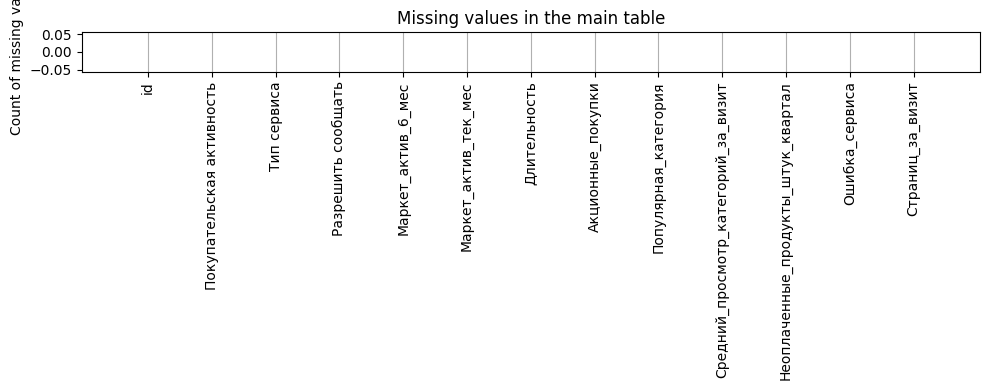

In [191]:
# Visualize missing values in the main table
plt.figure(figsize=(10, 4))
na_counts = df_main.isna().sum()

plt.bar(df_main.columns, na_counts)
plt.xticks(rotation=90)
plt.title('Missing values in the main table')
plt.ylabel('Count of missing values')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [192]:
# Type conversion
# Check if there are any non-numeric values in numeric columns
for col in df_main.select_dtypes(include='object').columns:
    print(f'{col}: {df_main[col].unique()[:5]}...')  # first 5 unique values


Покупательская активность: ['Снизилась' 'Прежний уровень']...
Тип сервиса: ['премиум' 'стандартт' 'стандарт']...
Разрешить сообщать: ['да' 'нет']...
Популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда']...


In [193]:
# Remove duplicates, if any
df_main = df_main.drop_duplicates()
df_revenue = df_revenue.drop_duplicates()
df_time = df_time.drop_duplicates()
df_profit = df_profit.drop_duplicates()

In [194]:
# Normalization
# ---- main → df_main_clean ----
m = df_main.copy()

m['customer_id'] = pd.to_numeric(m['id'], errors='coerce').astype('Int64')

m['customer_activity'] = (
    m['Покупательская активность'].astype(str).str.strip().str.lower()
      .replace({'снизилась':'decreased','выросла':'increased','стабильно':'stable',
                'прежний уровень':'stable','прежний_уровень':'stable'})
)

m['service_tier'] = (
    m['Тип сервиса'].astype(str).str.strip().str.lower()
      .replace({'премиум':'premium','стандарт':'standard','стандартт':'standard'})
)

m['allow_notifications'] = (
    m['Разрешить сообщать'].astype(str).str.strip().str.lower()
      .replace({'да': 1, 'нет': 0})
).astype('boolean')

def to_num(s: pd.Series) -> pd.Series:
    """Normalize '1 234,56' → 1234.56 and cast to numeric."""
    return pd.to_numeric(
        s.astype(str).str.replace(' ', '', regex=False).str.replace(',', '.', regex=False),
        errors='coerce'
    )

m['duration_days'] = pd.to_numeric(m['Длительность'], errors='coerce').astype('Int64')
m['marketing_activity_6m'] = to_num(m['Маркет_актив_6_мес'])
m['marketing_activity_curr_m'] = to_num(m['Маркет_актив_тек_мес'])
m['promo_purchases'] = to_num(m['Акционные_покупки'])

# Map popular_category to English
cat_map = {
    'Товары для детей': 'Kids products',
    'Домашний текстиль': 'Home textiles',
    'Косметика и аксесуары': 'Cosmetics & accessories',
    'Техника для красоты и здоровья': 'Beauty & health appliances',
    'Мелкая бытовая техника и электроника': 'Small appliances & electronics',
    'Кухонная посуда': 'Kitchen cookware',
}
m['popular_category'] = m['Популярная_категория'].astype(str).str.strip().replace(cat_map)

m['avg_categories_per_visit'] = pd.to_numeric(m['Средний_просмотр_категорий_за_визит'], errors='coerce').astype('Int64')
m['unpaid_products_qtr'] = pd.to_numeric(m['Неоплаченные_продукты_штук_квартал'], errors='coerce').astype('Int64')
m['service_error_flag'] = pd.to_numeric(m['Ошибка_сервиса'], errors='coerce').astype('Int64')
m['pages_per_visit'] = pd.to_numeric(m['Страниц_за_визит'], errors='coerce').astype('Int64')

df_main_clean = m[[
    'customer_id','customer_activity','service_tier','allow_notifications',
    'duration_days','marketing_activity_6m','marketing_activity_curr_m',
    'promo_purchases','popular_category','avg_categories_per_visit',
    'unpaid_products_qtr','service_error_flag','pages_per_visit'
]].copy()

# ---- revenue (market_money) → df_revenue_clean ----
r = df_revenue.copy()
r['state_id'] = pd.to_numeric(r['id'], errors='coerce').astype('Int64')
r['period'] = (
    r['Период'].astype(str).str.strip().str.lower()
      .replace({'текущий_месяц':'current_month',
                'предыдущий_месяц':'prev_month',
                'препредыдущий_месяц':'prev_prev_month',
                'предыдцщий_месяц':'prev_month'})
)
r['revenue'] = to_num(r['Выручка'])
df_revenue_clean = r[['state_id','period','revenue']].copy()

# ---- time (market_time) → df_time_clean ----
t = df_time.copy()
t['time_chunk_id'] = pd.to_numeric(t['id'], errors='coerce').astype('Int64')
t['period'] = (
    t['Период'].astype(str).str.strip().str.lower()
      .replace({'текущий_месяц':'current_month',
                'предыдущий_месяц':'prev_month',
                'препредыдущий_месяц':'prev_prev_month',
                'предыдцщий_месяц':'prev_month'})
)
t['minutes_spent'] = pd.to_numeric(t['минут'], errors='coerce').astype('Int64')
df_time_clean = t[['time_chunk_id','period','minutes_spent']].copy()

# ---- profit (money) → df_profit_clean ----
p = df_profit.copy()
p['money_id'] = pd.to_numeric(p['id'], errors='coerce').astype('Int64')
p['profit'] = to_num(p['Прибыль'])
df_profit_clean = p[['money_id','profit']].copy()


In [195]:
# Check shapes after cleaning
print(f'Main table: {df_main.shape}')
print(f'Revenue: {df_revenue.shape}')
print(f'Time on site: {df_time.shape}')
print(f'Profit: {df_profit.shape}')


Main table: (1300, 13)
Revenue: (3900, 3)
Time on site: (2600, 3)
Profit: (1300, 2)


In [196]:
# Look at unique values of categorical variables
cat_columns = ['customer_activity', 'service_tier', 'popular_category']

for col in cat_columns:
    print(f'\n{col}:')
    print(df_main_clean[col].value_counts())



customer_activity:
customer_activity
stable       802
decreased    498
Name: count, dtype: int64

service_tier:
service_tier
standard    924
premium     376
Name: count, dtype: int64

popular_category:
popular_category
Kids products                     330
Home textiles                     251
Cosmetics & accessories           223
Beauty & health appliances        184
Small appliances & electronics    174
Kitchen cookware                  138
Name: count, dtype: int64


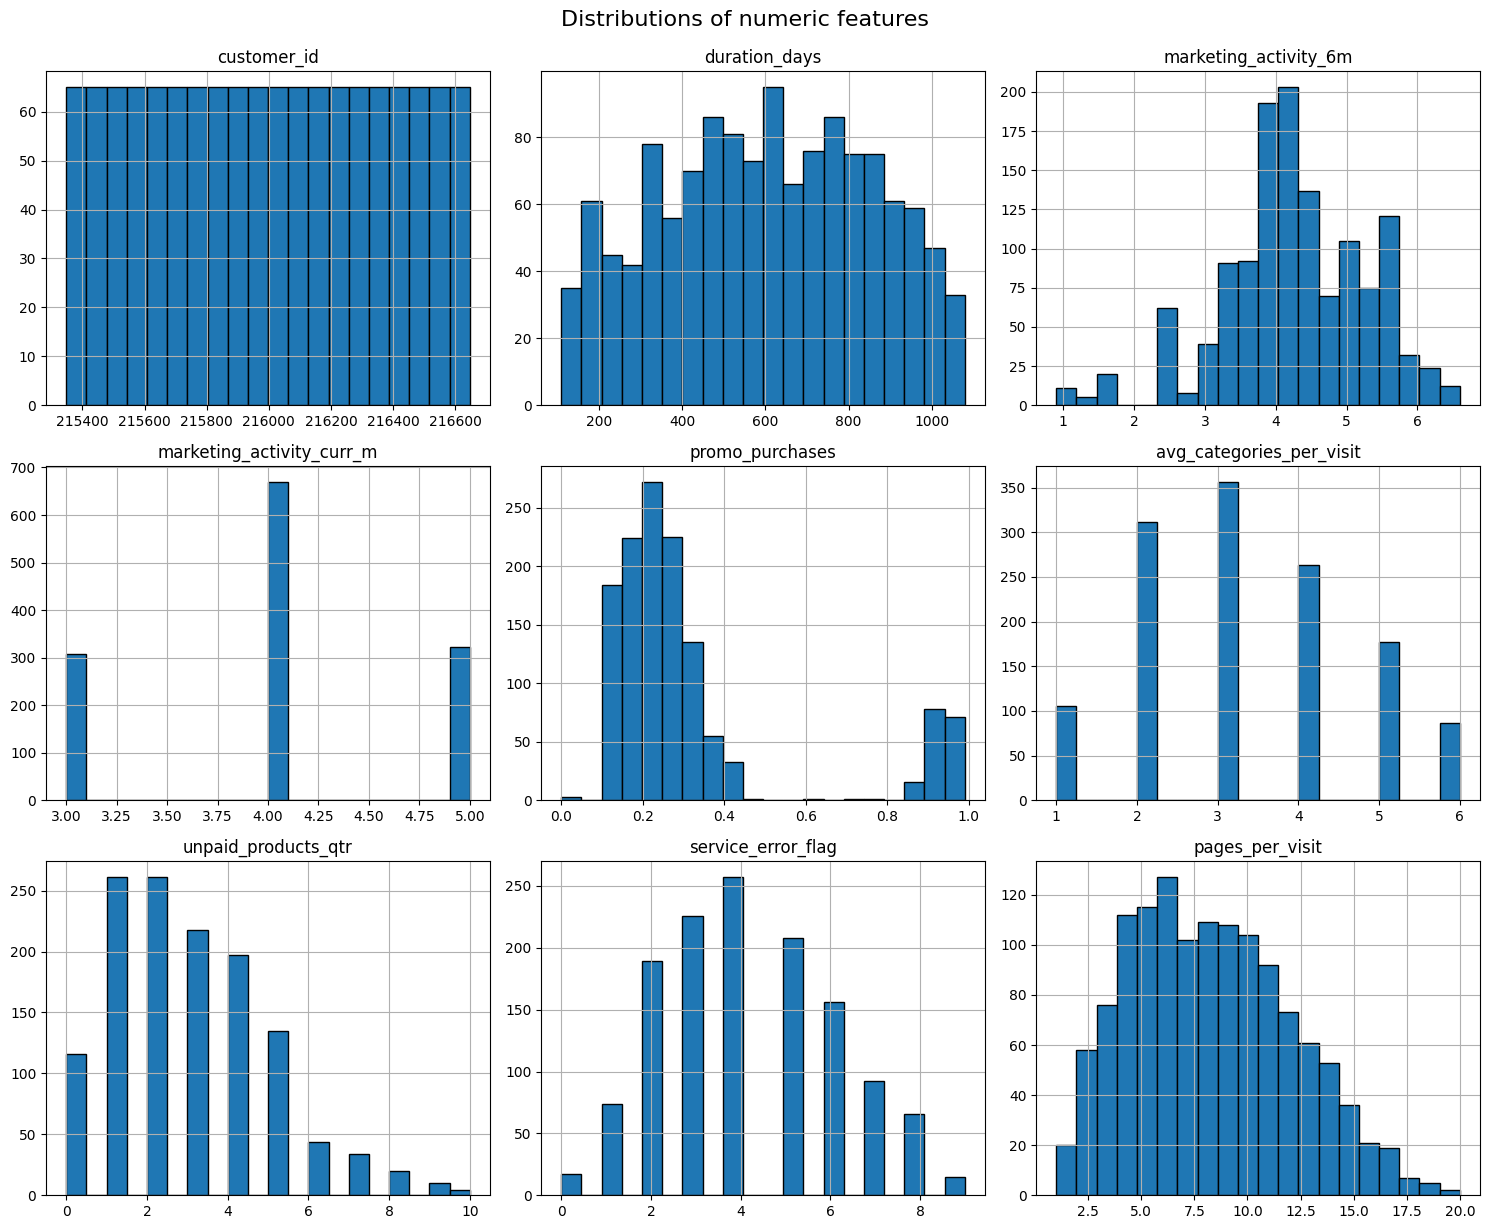

In [197]:
# Plot histograms for all numeric features

# Use the cleaned table
num_columns = df_main_clean.select_dtypes(include=[np.number]).columns

cols = 3
rows = math.ceil(len(num_columns) / cols)

plt.figure(figsize=(5 * cols, 4 * rows))
for i, col in enumerate(num_columns):
    plt.subplot(rows, cols, i + 1)
    plt.hist(df_main_clean[col].dropna(), bins=20, edgecolor='black')
    plt.title(col)
    plt.tight_layout()

plt.suptitle('Distributions of numeric features', y=1.02, fontsize=16)
plt.show()


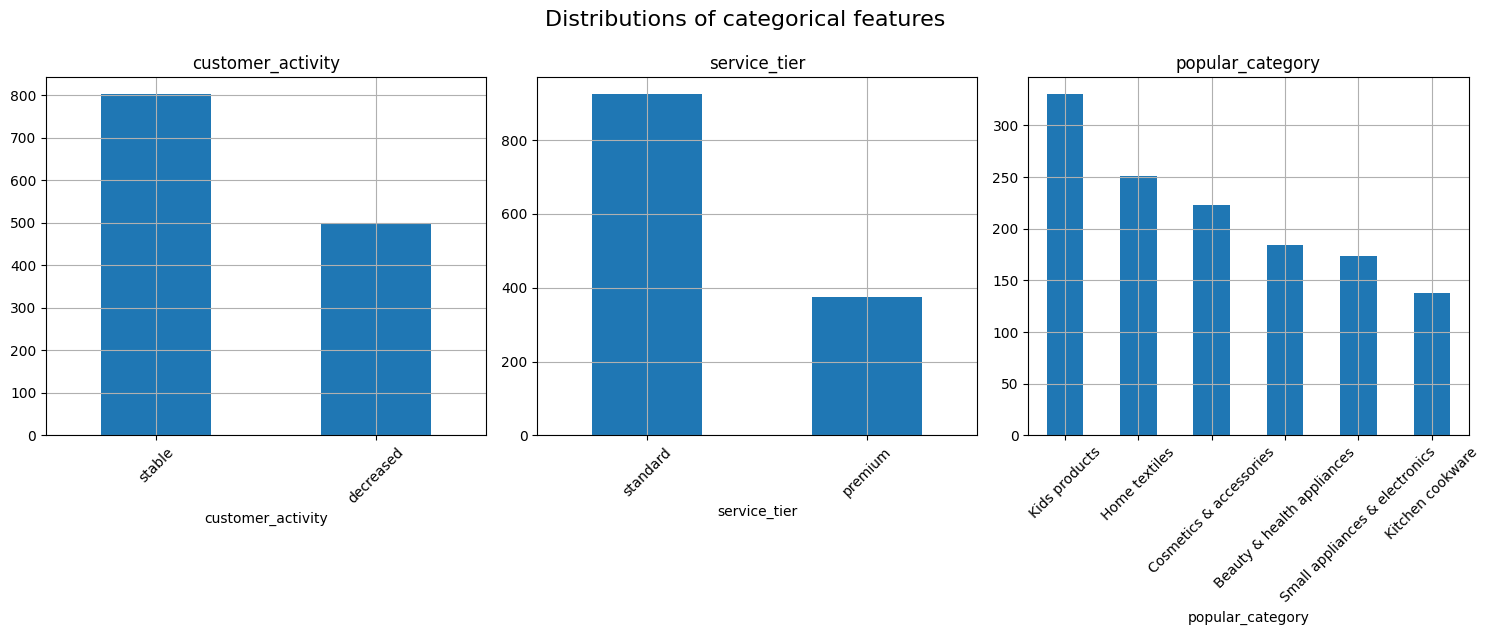

In [198]:
# Plots for categorical feature distributions
cat_columns = ['customer_activity', 'service_tier', 'popular_category']

plt.figure(figsize=(15, 6))
for i, col in enumerate(cat_columns):
    plt.subplot(1, 3, i + 1)
    df_main_clean[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.suptitle('Distributions of categorical features', y=1.05, fontsize=16)
plt.show()


In [199]:
# Checks for duplicates in cleaned datasets

# Check 1: main dataset (should be 1 row per customer)
duplicate_main = df_main_clean[df_main_clean.duplicated(subset='customer_id', keep=False)]
print(f'Duplicate customer_id in market_file: {duplicate_main.shape[0]}')
if not duplicate_main.empty:
    display(duplicate_main)

# Check 2: revenue — implicit duplicates by (id + period)
duplicate_revenue = df_revenue_clean[df_revenue_clean.duplicated(subset=['state_id', 'period'], keep=False)]
print(f'Implicit duplicates in market_money by (state_id, period): {duplicate_revenue.shape[0]}')
if not duplicate_revenue.empty:
    display(duplicate_revenue.sort_values(by=['state_id', 'period']))

# Check 3: time — implicit duplicates by (id + period)
duplicate_time = df_time_clean[df_time_clean.duplicated(subset=['time_chunk_id', 'period'], keep=False)]
print(f'Implicit duplicates in market_time by (time_chunk_id, period): {duplicate_time.shape[0]}')
if not duplicate_time.empty:
    display(duplicate_time.sort_values(by=['time_chunk_id', 'period']))

# Check 4: profit — should be one id per row
duplicate_profit = df_profit_clean[df_profit_clean.duplicated(subset='money_id', keep=False)]
print(f'Duplicate money_id in money.csv: {duplicate_profit.shape[0]}')
if not duplicate_profit.empty:
    display(duplicate_profit)


Duplicate customer_id in market_file: 0
Implicit duplicates in market_money by (state_id, period): 0
Implicit duplicates in market_time by (time_chunk_id, period): 0
Duplicate money_id in money.csv: 0


## Revenue Outlier Analysis and Removal

Goal: exclude customers with abnormally high revenue so the model is not distorted by extreme values.

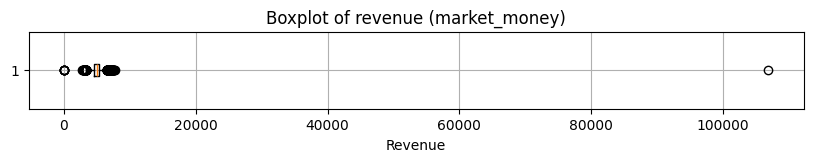

In [200]:
# Boxplot of revenue
plt.figure(figsize=(10, 1))
plt.boxplot(df_revenue_clean['revenue'], vert=False)
plt.title('Boxplot of revenue (market_money)')
plt.xlabel('Revenue')
plt.grid(True, axis='x')
plt.show()


We will cut off the extreme upper outlier without touching smaller values.

In [201]:
# Interquartile range (IQR) upper bound
Q1 = df_revenue_clean['revenue'].quantile(0.25)
Q3 = df_revenue_clean['revenue'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print(f'Upper cap: {upper_bound:.2f}')

# Filter: keep only reasonable revenue values
df_revenue_clean = df_revenue_clean[df_revenue_clean['revenue'] <= upper_bound]


Upper cap: 6522.28


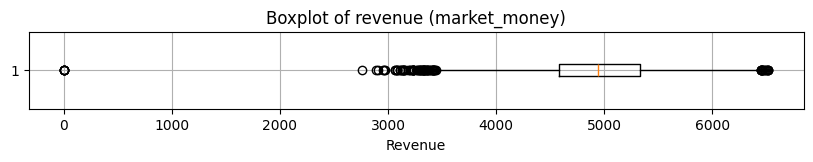

In [202]:
# Boxplot of revenue (after filtering)
plt.figure(figsize=(10, 1))
plt.boxplot(df_revenue_clean['revenue'], vert=False)
plt.title('Boxplot of revenue (market_money)')
plt.xlabel('Revenue')
plt.grid(True, axis='x')
plt.show()


## Filtering Out Inactive Customers

Goal:
Remove customers who made no purchases in at least one month.

- Compute total revenue per `id`.
- Keep only those who had purchases.
- Filter all tables by these `id`s.


In [203]:
# Convert the table to a wide format
revenue_raw = pd.read_csv('data/market_money.csv')
revenue_pivot = revenue_raw.pivot(index='id', columns='Период', values='Выручка')

# Find customers who have at least one month = 0
ids_to_remove = revenue_pivot[revenue_pivot.isna().any(axis=1) | (revenue_pivot == 0).any(axis=1)].index

print(f'Removing customers: {len(ids_to_remove)} — {list(ids_to_remove)}')

# Filter all tables
df_main = df_main[~df_main['id'].isin(ids_to_remove)]
df_revenue = df_revenue[~df_revenue['id'].isin(ids_to_remove)]
df_time = df_time[~df_time['id'].isin(ids_to_remove)]
df_profit = df_profit[~df_profit['id'].isin(ids_to_remove)]
print(f"Remaining customers after filtering: {df_main['id'].nunique()}")


Removing customers: 3 — [215348, 215357, 215359]
Remaining customers after filtering: 1297


### Summary for Step 2: Data Preprocessing

- **Data types** in all tables were converted to correct formats; numeric and categorical features are recognized properly.
- **Missing values** and **duplicates** are absent in the main table (`market_file.csv`).
- **Typos** were fixed in the data: `'стандартт` → `'стандарт'`, `'предыдцщий_месяц'` → `'предыдущий_месяц'`.
- The `allow_notifications` feature was converted to a binary format: `да` → `1`, `нет` → `0`.
- The target feature `customer_activity` has two classes with moderate imbalance and is ready for binary encoding.
- Categorical features (`service_tier`, `popular_category`) have reasonable distributions and are ready for encoding.
- Overall, numeric features show no obvious outliers, except for one extreme outlier in the revenue table, which was filtered out; most are normally or discretely distributed.
- No implicit duplicates were found in `market_money` and `market_time` by the composite key `id + Период`.
- In `money.csv`, each `id` appears once; the structure is correct.

**Name/value mapping:**
- Columns: `Покупательская активность` → `customer_activity`, `Тип сервиса` → `service_tier`, `Разрешить сообщать` → `allow_notifications`, `Прибыль` → `profit`, `Выручка` → `revenue`, `минут` → `minutes_spent`, `Период` → `period`.
- Values: `снизилась`/`выросла`/`стабильно` → `decreased`/`increased`/`stable`; `премиум`/`стандарт(т)` → `premium`/`standard`; `да`/`нет` → `yes`/`no` (then 1/0); `текущий_месяц`/`предыдущий_месяц`/`препредыдущий_месяц` → `current_month`/`prev_month`/`prev_prev_month`.


# EDA

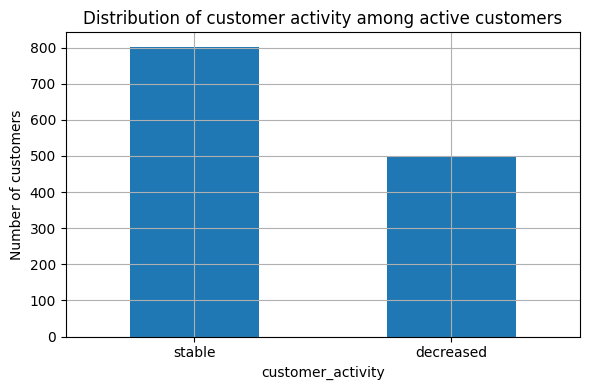

customer_activity
stable       61.69
decreased    38.31
Name: proportion, dtype: float64


In [204]:
# Plot the distribution of the target feature
plt.figure(figsize=(6, 4))
df_main_clean['customer_activity'].value_counts().plot(kind='bar')
plt.title('Distribution of customer activity among active customers')
plt.ylabel('Number of customers')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# in percent
print(round(df_main_clean['customer_activity'].value_counts(normalize=True) * 100, 2))


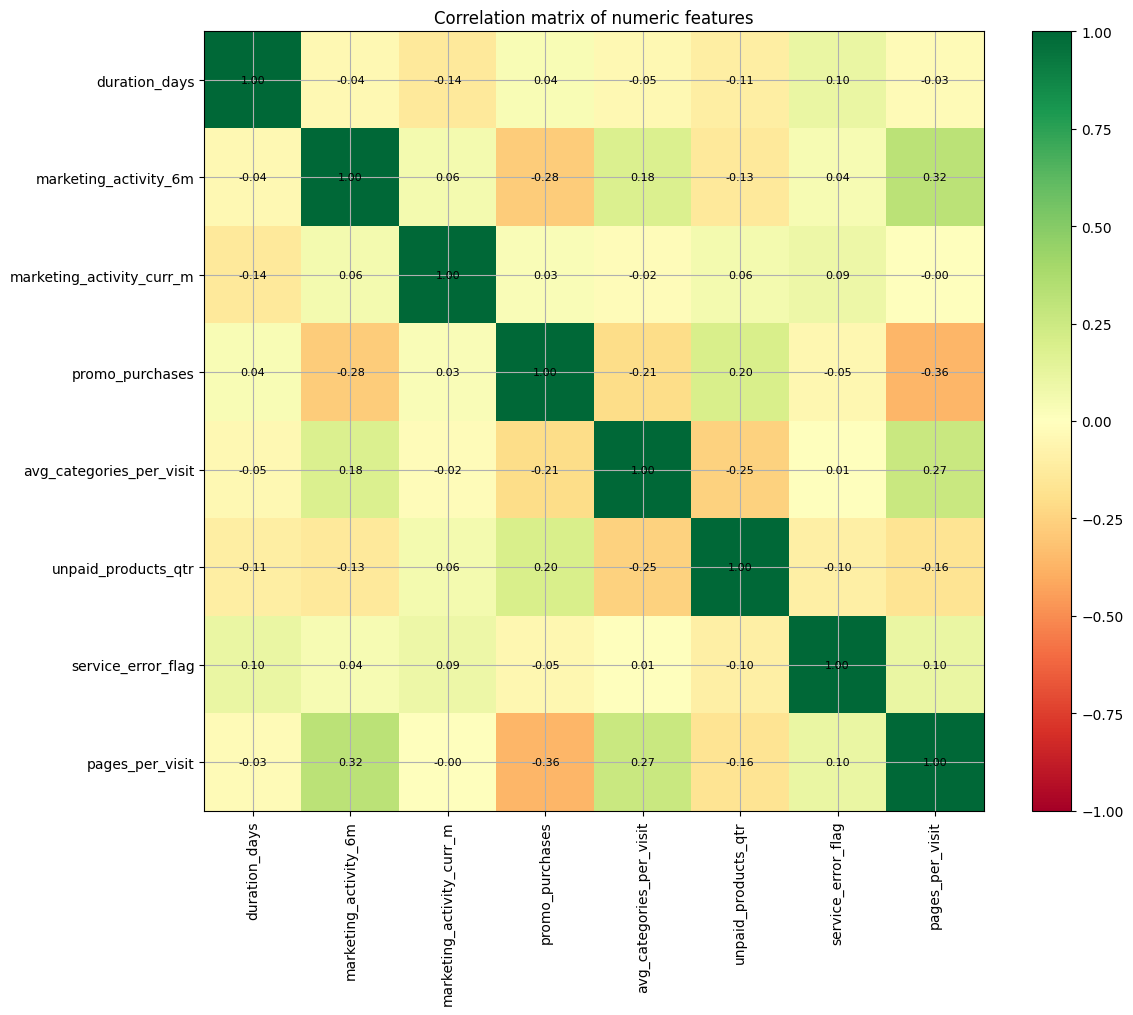

In [205]:
# Keep only numeric features
numeric_features = (
    df_main_clean
    .drop(columns=['customer_id', 'customer_activity'])
    .select_dtypes(include=[np.number])
)

# Compute correlation matrix
corr = numeric_features.corr(method='spearman')

# Heatmap
plt.figure(figsize=(12, 10))
im = plt.imshow(corr, cmap='RdYlGn', vmin=-1, vmax=1)

# Axis labels
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)

# Annotate cells
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i, j]:.2f}",
                 ha="center", va="center", color="black", fontsize=8)

# Colorbar and title
plt.colorbar(im)
plt.title('Correlation matrix of numeric features')
plt.tight_layout()
plt.show()


In [206]:
# List numeric features, excluding customer_id
num_cols = df_main_clean.select_dtypes(include=[np.number]).drop(columns='customer_id').columns

# Build an outlier summary
outliers_summary = {}

for col in num_cols:
    q1 = df_main_clean[col].quantile(0.25)
    q3 = df_main_clean[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df_main_clean[(df_main_clean[col] < lower) | (df_main_clean[col] > upper)]
    outliers_summary[col] = len(outliers)

# Print the number of outliers per feature
for col, count in outliers_summary.items():
    print(f'{col}: {count} outliers')


duration_days: 0 outliers
marketing_activity_6m: 36 outliers
marketing_activity_curr_m: 631 outliers
promo_purchases: 168 outliers
avg_categories_per_visit: 0 outliers
unpaid_products_qtr: 14 outliers
service_error_flag: 0 outliers
pages_per_visit: 0 outliers


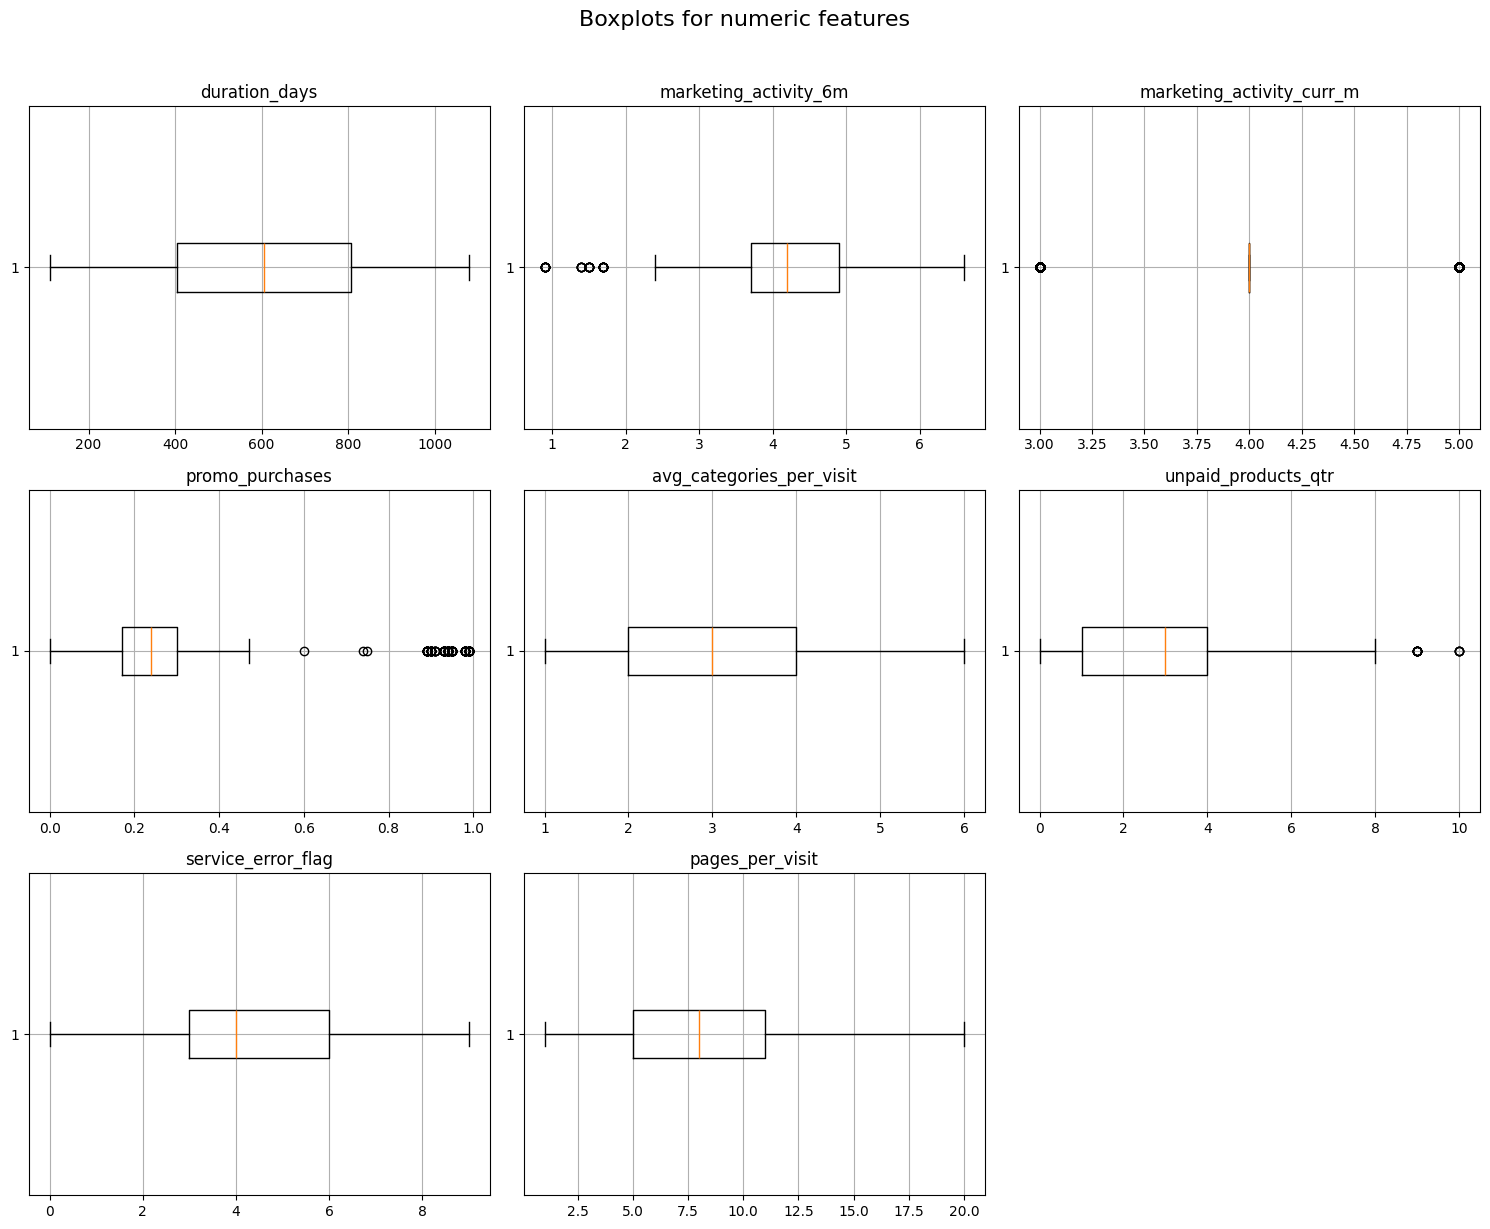

In [207]:
# Visualize outliers
cols = 3
rows = (len(num_cols) + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(num_cols):
    plt.subplot(rows, cols, i + 1)
    plt.boxplot(df_main_clean[col].dropna(), vert=False)
    plt.title(col)

plt.suptitle('Boxplots for numeric features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


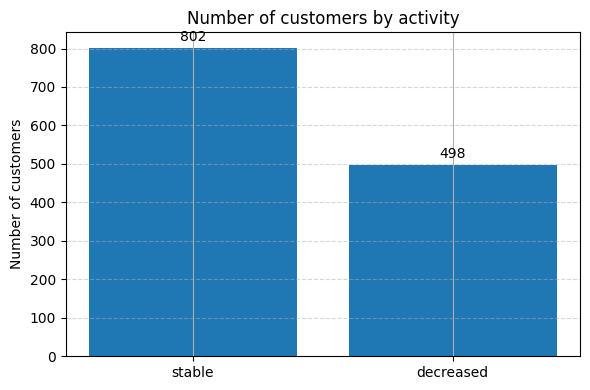

Number of active customers: 1300


In [208]:
# Count customers by activity category
activity_counts = df_main_clean['customer_activity'].value_counts()
activity_labels = activity_counts.index
activity_values = activity_counts.values

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(activity_labels, activity_values)

# Annotations above bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 10, f'{int(height)}',
             ha='center', va='bottom')

plt.title('Number of customers by activity')
plt.ylabel('Number of customers')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f'Number of active customers: {df_main_clean.shape[0]}')


### Summary for Step 3: Exploratory Data Analysis

- Customers with purchases in every month of the period: **1300**.
- Most customers (**802**) remained **stable**, **498** **decreased**.
- Target distribution: **~62.3% stable** and **~37.7% decreased** — classes are moderately balanced.
- Correlations:
  - No strong multicollinearity detected.
  - The strongest positive correlations are among on-site behavior features:
    `pages_per_visit`, `avg_categories_per_visit`, `duration_days`.
- Outliers:
  - Most outliers are in `marketing_activity_curr_m`, `promo_purchases`, and `unpaid_products_qtr`.
  - Outliers are retained as potentially meaningful aspects of customer behavior.


# Merging tables

In [209]:
# Pivot revenue
df_revenue_wide = (
    df_revenue_clean
      .pivot(index='state_id', columns='period', values='revenue')
      .reset_index()
)
df_revenue_wide.columns.name = None
df_revenue_wide = df_revenue_wide.rename(columns={
    'current_month': 'revenue_current',
    'prev_month': 'revenue_prev',
    'prev_prev_month': 'revenue_prev_prev'
})

# Pivot time
df_time_wide = (
    df_time_clean
      .pivot(index='time_chunk_id', columns='period', values='minutes_spent')
      .reset_index()
)
df_time_wide.columns.name = None
df_time_wide = df_time_wide.rename(columns={
    'current_month': 'time_current',
    'prev_month': 'time_prev',
    'prev_prev_month': 'time_prev_prev'
})


In [210]:
# Merge tables (use cleaned data and English keys)
df_full = df_main_clean.merge(
    df_revenue_wide.rename(columns={'state_id': 'customer_id'}),
    on='customer_id', how='left'
)
df_full = df_full.merge(
    df_time_wide.rename(columns={'time_chunk_id': 'customer_id'}),
    on='customer_id', how='left'
)

# Check size
print(f'Combined table size: {df_full.shape[0]} rows')


Combined table size: 1300 rows


### Histograms and box plots for numeric features; bar charts by groups for categorical features


In [211]:
# Split data into groups
df_active = df_full[df_full['customer_activity'] == 'stable']
df_dropped = df_full[df_full['customer_activity'] == 'decreased']


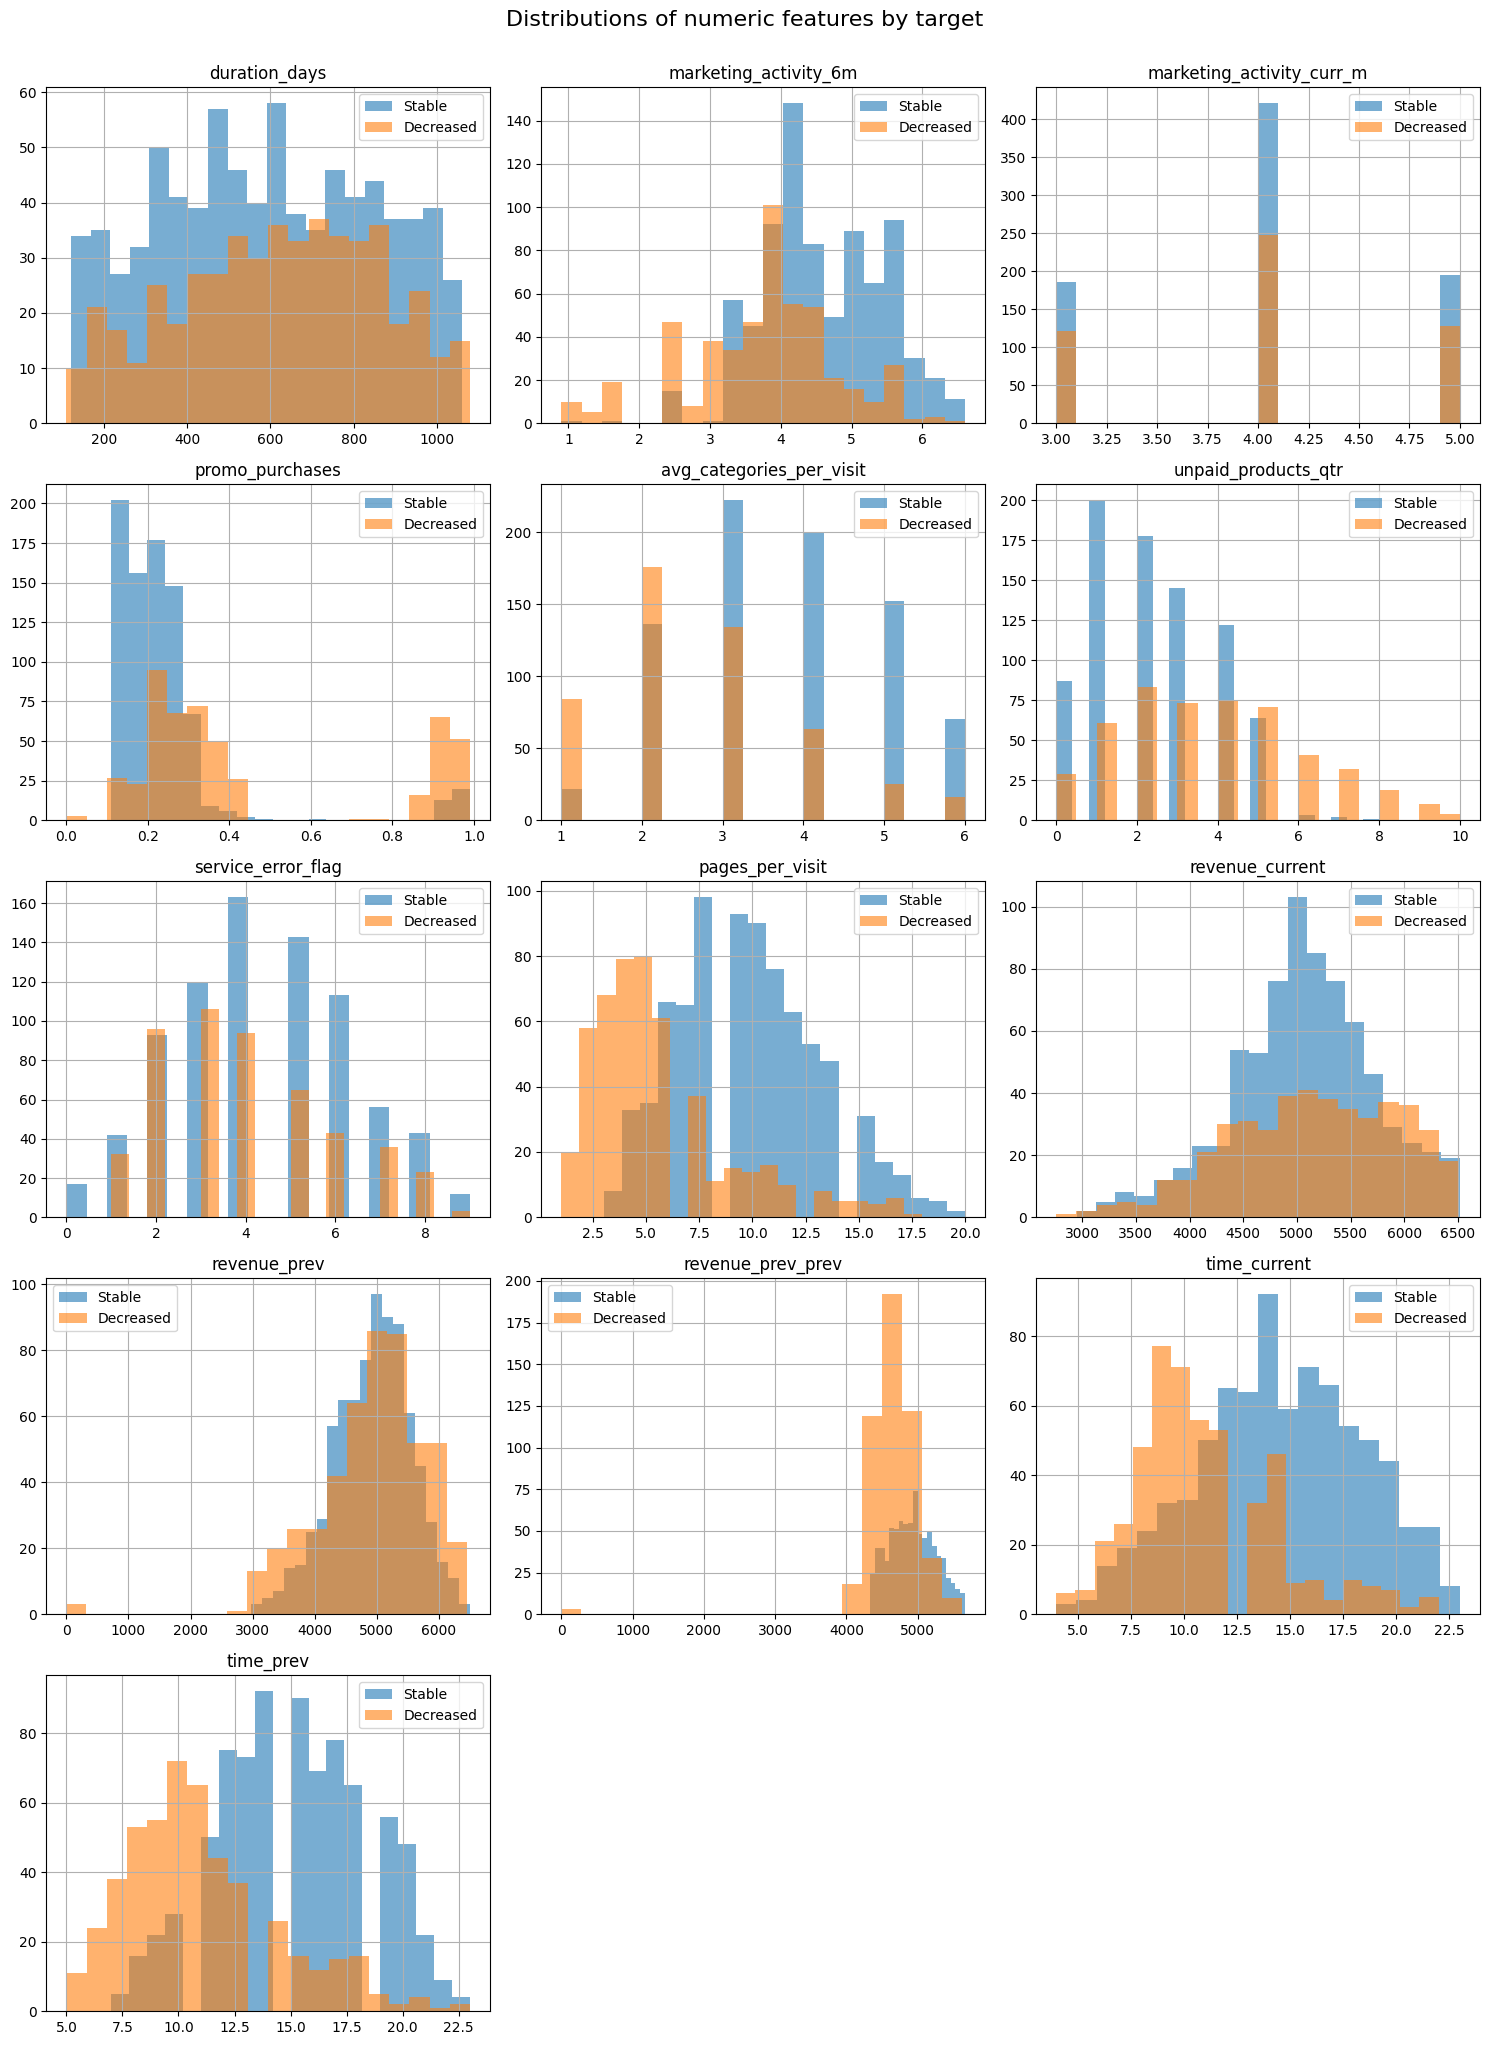

In [212]:
# Compare numeric features
# List numeric features excluding customer_id
num_cols = df_full.select_dtypes(include=['int64', 'float64']).drop(columns='customer_id').columns

# Overlaid histograms
cols = 3
rows = (len(num_cols) + cols - 1) // cols
plt.figure(figsize=(5 * cols, 4 * rows))

for i, col in enumerate(num_cols):
    plt.subplot(rows, cols, i + 1)
    plt.hist(df_active[col].dropna(), bins=20, alpha=0.6, label='Stable')
    plt.hist(df_dropped[col].dropna(), bins=20, alpha=0.6, label='Decreased')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.suptitle('Distributions of numeric features by target', y=1.02, fontsize=16)
plt.show()


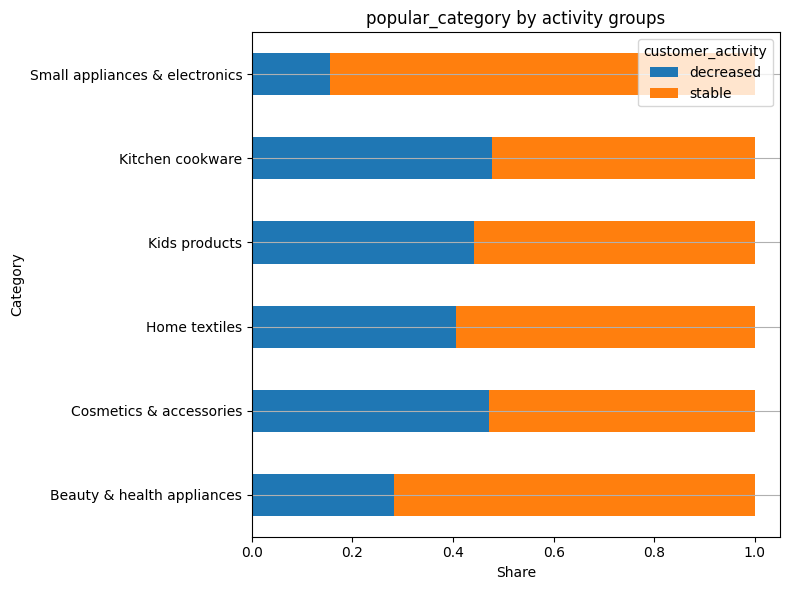

In [213]:
# Categorical feature
col = 'popular_category'
ctab = pd.crosstab(df_full[col], df_full['customer_activity'], normalize='index')

ctab.plot(kind='barh', stacked=True, figsize=(8, 6))
plt.title(f'{col} by activity groups')
plt.xlabel('Share')
plt.ylabel('Category')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


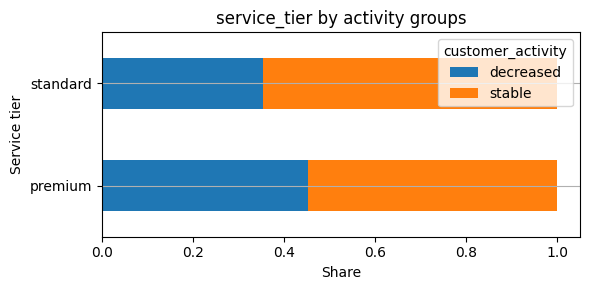

In [214]:
# Horizontal stacked bar for 'service_tier'
col = 'service_tier'
ctab = pd.crosstab(df_full[col], df_full['customer_activity'], normalize='index')

ctab.plot(kind='barh', stacked=True, figsize=(6, 3))
plt.title(f'{col} by activity groups')
plt.xlabel('Share')
plt.ylabel('Service tier')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


### Summary for Step 4: Merging Tables

- The `market_money.csv` table was reshaped from long to wide with columns: `revenue_current`, `revenue_prev`, `revenue_prev_prev`.
- The `market_time.csv` table was reshaped similarly with: `time_current`, `time_prev`. The `time_prev_prev` feature is **absent** in the raw data.
- All reshaped tables were merged with the main table (`market_file.csv`) by the key `customer_id`. Final table size: **1300 rows** and **18 features**.
- The profit table (`money.csv`) contains unique `id`s that fully match the main table and will be used later at the segmentation stage.

Based on the visual analysis of distributions, customers whose activity **decreased** show the following patterns:

- **Communications:** they less often opt in to notifications (`allow_notifications`), receiving fewer marketing touches.
- **On-site behavior:** they view fewer pages and categories and spend less time on the site (`pages_per_visit`, `avg_categories_per_visit`, `duration_days`).
- **Promos & purchases:** they make fewer promo purchases and leave fewer unpaid items in the cart (`promo_purchases`, `unpaid_products_qtr`).
- **Financials:** they have lower revenue in each of the three months (`revenue_current`, `revenue_prev`, `revenue_prev_prev`).
- **Category interests:** they buy **cosmetics** and **cookware** more often; less often — **kids’ products** and **appliances** (`popular_category`).
- **Service tier:** they are more frequently on the `standard` tier (`service_tier`).

Thus, decreased-activity customers exhibit lower engagement and loyalty. These behavioral patterns can be leveraged for modeling and subsequent segmentation.


# Featuring

In [215]:
# Feature preparation and target column

# Target mapping
df_full['customer_activity'] = df_full['customer_activity'].map({
    'decreased': 1,
    'stable': 0
})

# Target and features
target = 'customer_activity'
X = df_full.drop(columns=[target])
y = df_full[target]

# Feature lists
cat_features = ['service_tier', 'popular_category']
num_features = [col for col in X.columns if col not in ['customer_id'] + cat_features]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


In [216]:
# After set target/X/y
target = 'customer_activity'
X = df_full.drop(columns=[target])
y = df_full[target]

# Build feature lists FROM X
cat_features = X.select_dtypes(include='object').columns.tolist()
num_features = X.select_dtypes(include=[np.number]).drop(columns='customer_id').columns.tolist()

# Rebuild preprocessors with the corrected lists
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

num_transformer_standard = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

num_transformer_minmax = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

preprocessor_options = {
    'standard': ColumnTransformer([
        ('num', num_transformer_standard, num_features),
        ('cat', cat_transformer,        cat_features)
    ]),
    'minmax': ColumnTransformer([
        ('num', num_transformer_minmax, num_features),
        ('cat', cat_transformer,        cat_features)
    ])
}

# Model dict with hyperparameters, including the preprocessor
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'preprocessor': [preprocessor_options['standard'], preprocessor_options['minmax']],
            'model__C': [0.01, 0.1, 1, 5, 10]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'preprocessor': [preprocessor_options['standard'], preprocessor_options['minmax']],
            'model__max_depth': [3, 5, 8, 10, 15],
            'model__min_samples_split': [2, 4, 5, 10]
        }
    },
    'KNeighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'preprocessor': [preprocessor_options['standard'], preprocessor_options['minmax']],
            'model__n_neighbors': [3, 5, 7, 9],
            'model__weights': ['uniform', 'distance']
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'preprocessor': [preprocessor_options['standard'], preprocessor_options['minmax']],
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    }
}


In [217]:
best_models = {}

for name, item in models.items():
    print(f"\n====== Search for model: {name} ======")

    # Build a pipeline with a placeholder preprocessor (to be set by Grid/RandomizedSearch)
    pipe = Pipeline(steps=[
        ('preprocessor', 'passthrough'),
        ('model', item['model'])
    ])

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        pipe,
        item['params'],
        scoring='roc_auc',
        cv=5,
        n_iter=10,
        random_state=42,
        n_jobs=-1
    )

    # Train
    search.fit(X_train, y_train)
    y_pred_proba = search.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC: {score:.4f}")

    # Save result
    best_models[name] = {
        'model': search.best_estimator_,
        'score': score
    }



====== Search for model: LogisticRegression ======
ROC AUC: 0.9123

====== Search for model: DecisionTree ======
ROC AUC: 0.8494

====== Search for model: KNeighbors ======
ROC AUC: 0.9129

====== Search for model: SVC ======
ROC AUC: 0.9009


### Summary for Step 6: Model Building

- Trained four models (`LogisticRegression`, `DecisionTree`, `KNeighbors`, `SVC`) using pipelines with hyperparameter tuning via `RandomizedSearchCV`.
- Primary metric: **ROC AUC** (binary classification with moderate class imbalance).
- Tested two scaling options for features: `StandardScaler` and `MinMaxScaler` (as required).

**Results (ROC AUC on test):**
- `KNeighborsClassifier` — **0.9129**  ← best
- `LogisticRegression` — **0.9123**
- `SVC` — **0.9009**
- `DecisionTree` — **0.8494**

**Conclusion:**
Proceed with **`KNeighborsClassifier`** for further feature importance/interpretation steps (and compare with `LogisticRegression` as a strong baseline).


# Model interpretation

In [218]:
# Find the model with the highest ROC AUC
best_key = max(best_models, key=lambda k: best_models[k]['score'])
best_model = best_models[best_key]['model']

print(f'Best model: {best_key} with ROC AUC = {best_models[best_key]["score"]:.4f}')

# Extract preprocessor and model from the pipeline
preprocessor = best_model.named_steps['preprocessor']
model = best_model.named_steps['model']

# Show the scaler used inside the numeric transformer of the selected preprocessor
print(preprocessor.transformers[0][1].named_steps['scaler'])


Best model: KNeighbors with ROC AUC = 0.9129
StandardScaler()


In [219]:
# Transform the training set
X_train_transformed = preprocessor.transform(X_train)

# Get categorical feature names (OneHotEncoder with drop='first')
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(cat_features)

# Combine with numeric
all_feature_names = list(ohe_feature_names) + num_features


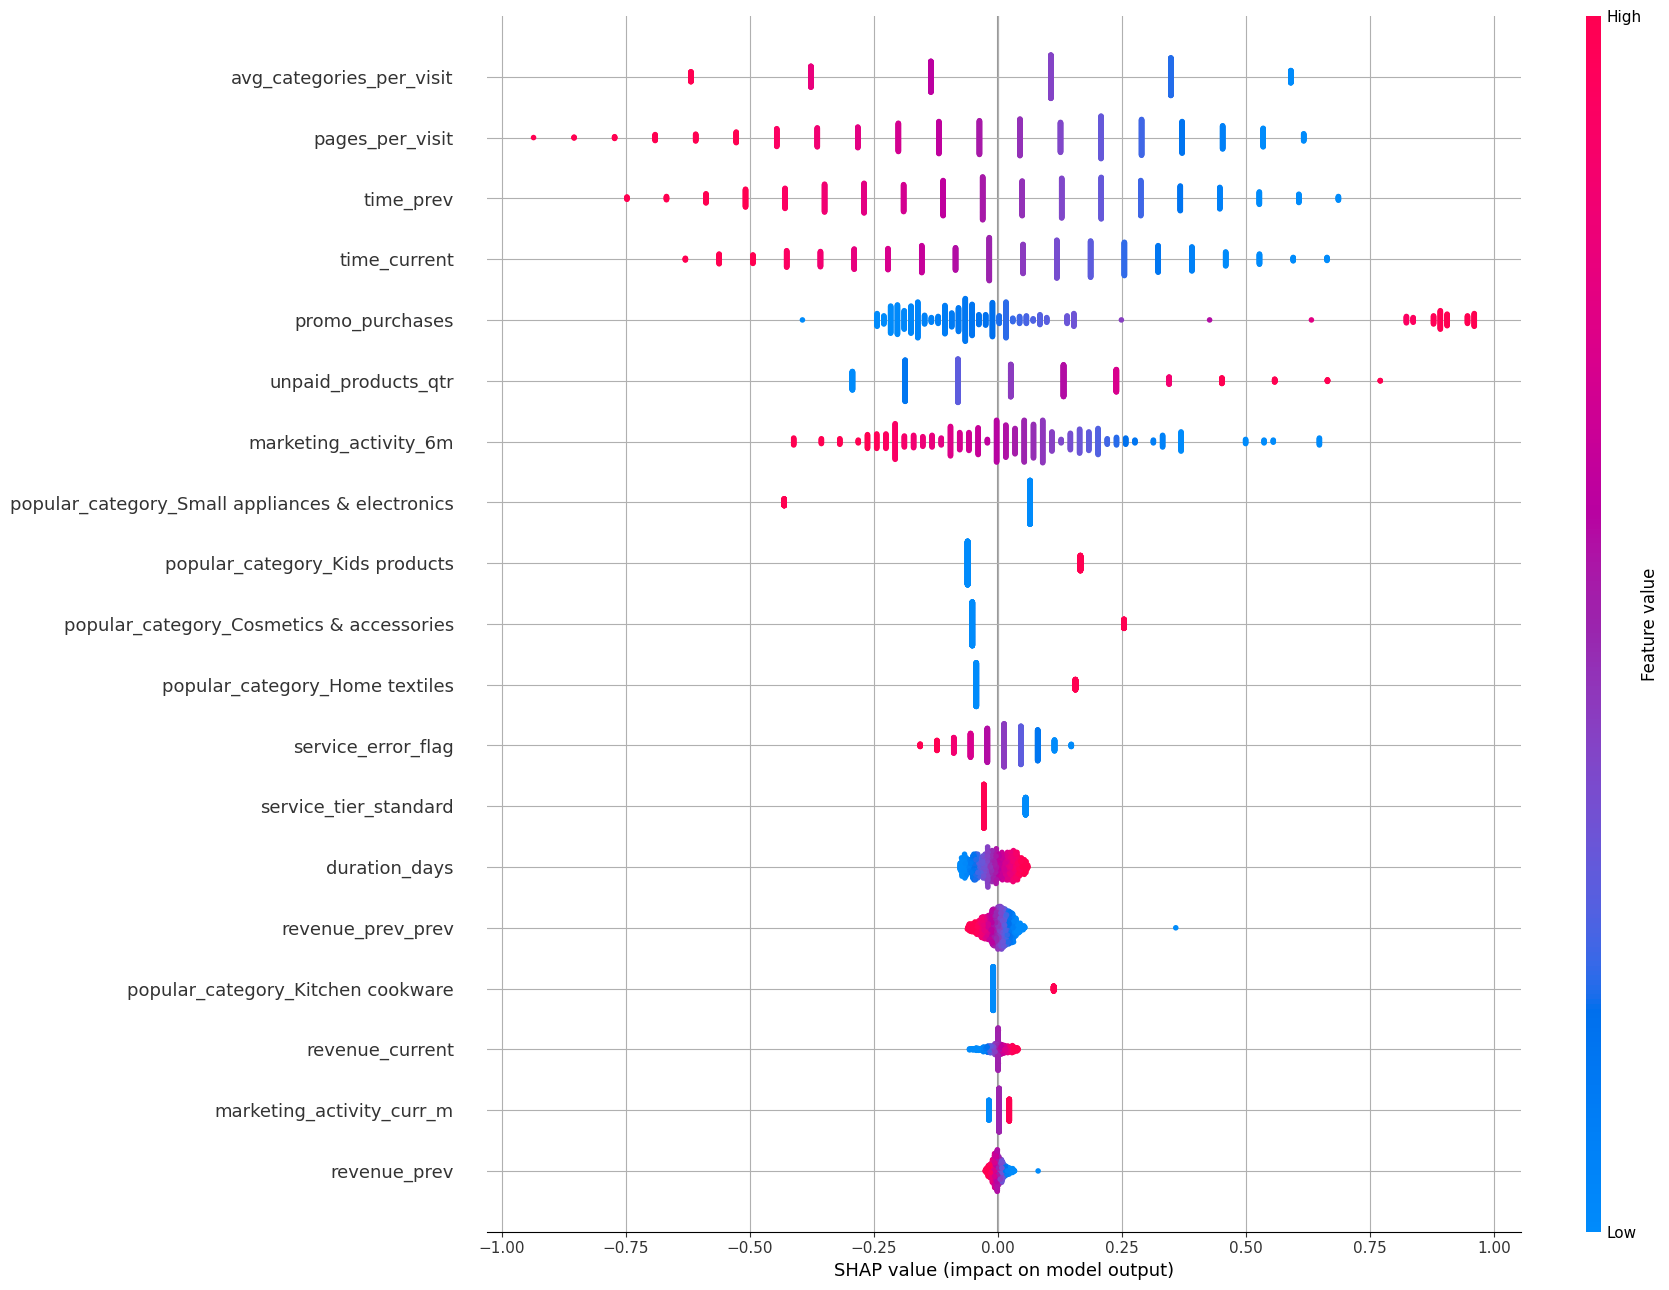

In [220]:
# Find the best LogisticRegression by score
log_keys = [k for k in best_models if k.startswith('LogisticRegression')]
best_log_key = max(log_keys, key=lambda k: best_models[k]['score'])
log_model = best_models[best_log_key]['model']

# Get preprocessor and fitted model
preprocessor = log_model.named_steps['preprocessor']
model = log_model.named_steps['model']

# Transform the training set
X_train_transformed = preprocessor.transform(X_train)

# Get feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(cat_features)
all_feature_names = num_features + list(ohe_feature_names)

# Convert array to DataFrame
X_train_df = pd.DataFrame(X_train_transformed, columns=all_feature_names)

# SHAP for LogisticRegression
explainer = shap.Explainer(model, X_train_df)
shap_values = explainer(X_train_df)

# Plot
shap.summary_plot(
    shap_values.values,
    features=X_train_df,
    feature_names=all_feature_names,
    show=True,
    plot_size=(18, 13)
)


### Summary: Model Interpretation

- The strongest contributors to predicting **decreased activity** are:
  - **`pages_per_visit`** and **`avg_categories_per_visit`** — users who explore the site more actively have a lower risk of decreased activity.
  - **`unpaid_products_qtr`** — a higher number of abandoned items is positively associated with churn risk.
  - **`promo_purchases`** — frequent participation in promotions shifts predictions toward churn.
  - **`marketing_activity_6m`** — prolonged marketing exposure is linked to higher risk, especially at high values.

- Also meaningful:
  - Certain **categorical features**, especially customers preferring **“Small appliances & electronics”** and **“Beauty & health appliances”**, appear more often among lower-loyalty clients.
  - **`service_error_flag`** and **`duration_days`** reflect user experience and customer maturity.

- Less influential:
  - **`marketing_activity_curr_m`**, **`service_tier = standard`**, **`allow_notifications`**, and popular categories like **Cosmetics & accessories**, **Kitchen cookware**, and **Kids products**.

- **Conclusion:** the most informative features capture **on-site engagement** and **response to marketing activity**. These signals should guide customer segmentation and personalized retention strategies.


# Customer Segmentation and Recommendations

#### Segmentation Goal

In the previous steps, we studied the behavior of customers whose activity decreased and identified key features influencing churn: low on-site engagement, focus on promotions, and lower revenue.

Now, based on the model and the probabilities of decreased activity, we will identify specific customer groups for further analysis and personalized actions. The task is to determine which segments are most important for retention or require attention from a marketing perspective.

---

#### Logic for Choosing Segments

I decided to consider **three segments**, each with business significance:

- **Segment A:**
  Customers with a **high probability of decreased activity** and **high profit** at the same time.
  This is a key group for priority retention — losing these customers would be the most painful for the business.

- **Segment B:**
  Customers with a **high share of promo purchases** and **medium profit**.
  There is a risk of forming discount dependency and, as a result, reduced margins. This segment is important for rethinking marketing strategies.

- **Segment C:**
  Customers who buy **kids’ products** and have an **elevated churn risk**.
  A possible sign that the “Kids’ products” category has issues with interest/retention despite the importance of this audience (e.g., young families).

#### Why Exactly Three Segments

In segmentation, we are not just splitting users, but highlighting groups with different business risks and behavioral patterns:

- **Segment A** covers customers whose loss is most critical due to high profit.
- **Segment B** allows assessing the effectiveness of marketing and identifying customers prone to discounts.
- **Segment C** is important for analyzing behavior in a specific product category with potential risk.

This selection covers three different business hypotheses: retaining valuable customers, managing margins, and adjusting product/category strategies.


In [221]:
# 1. Predicted churn probabilities
X_all = df_full.drop(columns=['customer_activity'])
y_all = df_full['customer_activity']

# Probabilities from the model (1 — "decreased")
proba = best_model.predict_proba(X_all)[:, 1]

# Save to a dataframe
df_segmentation = pd.DataFrame({
    'customer_id': X_all['customer_id'],
    'churn_probability': proba
})

# 2. Join profit
df_segmentation = df_segmentation.merge(
    df_profit_clean.rename(columns={'money_id': 'customer_id'}),
    on='customer_id', how='left'
)

# 3. Add needed features from df_full
df_segmentation = df_segmentation.merge(
    df_full[['customer_id', 'promo_purchases', 'popular_category']],
    on='customer_id',
    how='left'
)

# Preview
display(df_segmentation.head())


,customer_id,churn_probability,profit,promo_purchases,popular_category
0,215348,0.698813,0.98,0.00,Kids products
1,215349,1.000000,4.16,0.75,Kids products
2,215350,0.339433,3.13,0.14,Home textiles
3,215351,1.000000,4.87,0.99,Kids products
4,215352,1.000000,4.21,0.94,Kids products


In [222]:
# Segment A: high profit and high churn risk
segment_A = df_segmentation[
    (df_segmentation['churn_probability'] > 0.7) &
    (df_segmentation['profit'] > 4.0)
]

# Segment B: high share of promo purchases and medium profit
segment_B = df_segmentation[
    (df_segmentation['promo_purchases'] > 0.7) &
    (df_segmentation['profit'].between(2.0, 4.0))
]

# Segment C: buyers of kids' products with elevated churn risk
segment_C = df_segmentation[
    (df_segmentation['popular_category'] == 'Kids products') &
    (df_segmentation['churn_probability'] > 0.5)
]

# Check sizes
print(f'Segment A: {segment_A.shape[0]} customers')
print(f'Segment B: {segment_B.shape[0]} customers')
print(f'Segment C: {segment_C.shape[0]} customers')


Segment A: 245 customers
Segment B: 80 customers
Segment C: 140 customers


### Summary: Customer Segmentation and Recommendations

Based on predicted churn probabilities and business features, three key segments were identified:

- **Segment A** — **245** customers with **high profit** and **high churn risk**.
  Critical for retention: **top priority**.

- **Segment B** — **80** customers with a **high share of promo purchases** and **medium profit**.
  Require rethinking marketing approaches: **margin risk**.

- **Segment C** — **140** customers who buy **kids’ products** with **elevated churn risk**.
  Possible retention issues in this category: review the **user journey** and **assortment**.

The segments are **non-overlapping** and reflect three distinct business hypotheses.
Outcome: a focused plan for next actions — **retention**, **marketing adjustment**, and **analysis of problematic product categories**.


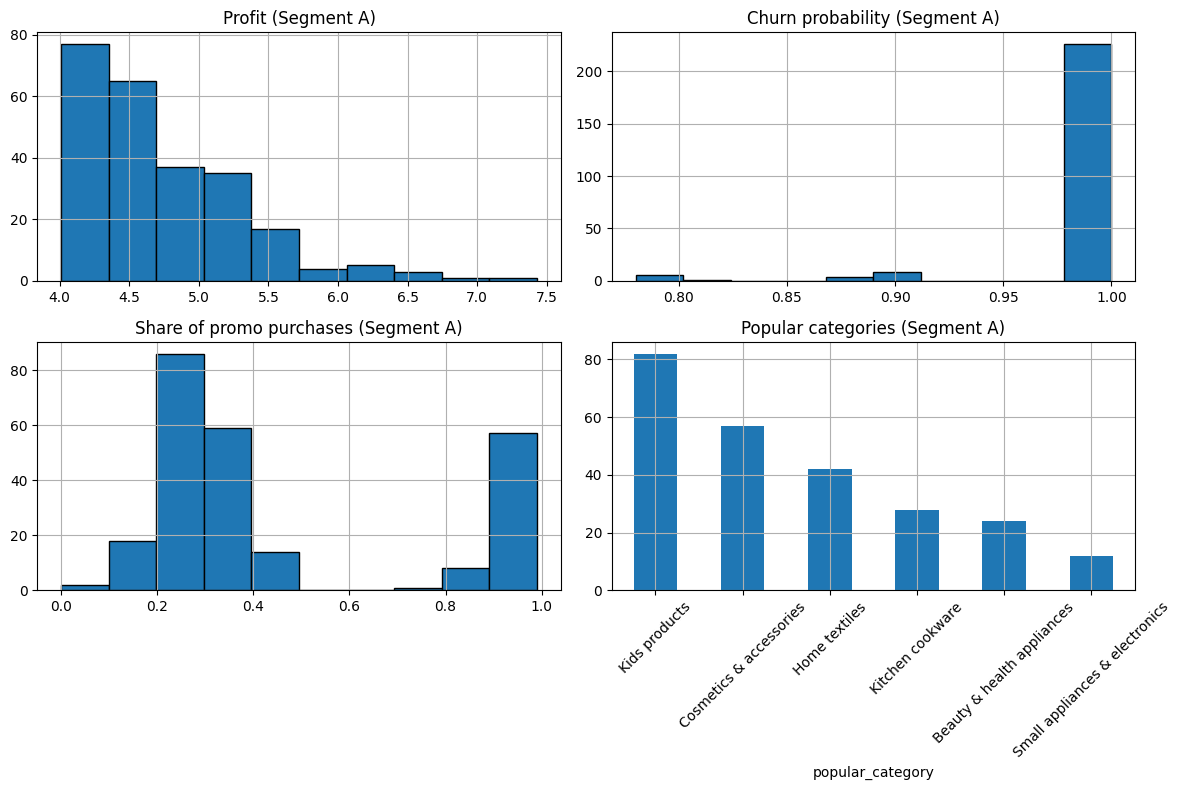

Average profit: 4.75
Average churn probability: 0.99
Average share of promo purchases: 0.45

Product categories:
popular_category
Kids products                     82
Cosmetics & accessories           57
Home textiles                     42
Kitchen cookware                  28
Beauty & health appliances        24
Small appliances & electronics    12
Name: count, dtype: int64


In [223]:
# 1. Visualization of distributions
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(segment_A['profit'], bins=10, edgecolor='black')
plt.title('Profit (Segment A)')

plt.subplot(2, 2, 2)
plt.hist(segment_A['churn_probability'], bins=10, edgecolor='black')
plt.title('Churn probability (Segment A)')

plt.subplot(2, 2, 3)
plt.hist(segment_A['promo_purchases'], bins=10, edgecolor='black')
plt.title('Share of promo purchases (Segment A)')

plt.subplot(2, 2, 4)
segment_A['popular_category'].value_counts().plot(kind='bar')
plt.title('Popular categories (Segment A)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. Summary stats
print("Average profit:", round(segment_A['profit'].mean(), 2))
print("Average churn probability:", round(segment_A['churn_probability'].mean(), 2))
print("Average share of promo purchases:", round(segment_A['promo_purchases'].mean(), 2))
print("\nProduct categories:")
print(segment_A['popular_category'].value_counts())


In [224]:
print(df_full.columns)


Index(['customer_id', 'customer_activity', 'service_tier',
       'allow_notifications', 'duration_days', 'marketing_activity_6m',
       'marketing_activity_curr_m', 'promo_purchases', 'popular_category',
       'avg_categories_per_visit', 'unpaid_products_qtr', 'service_error_flag',
       'pages_per_visit', 'revenue_current', 'revenue_prev',
       'revenue_prev_prev', 'time_current', 'time_prev'],
      dtype='object')



Segment A: Average revenue dynamics by category


,curr_minus_prev,prev_minus_prevprev
popular_category,,
Beauty & health appliances,562.73,-126.67
Cosmetics & accessories,330.23,513.25
Home textiles,377.36,485.49
Kids products,252.22,-27.88
Kitchen cookware,394.58,634.32
Small appliances & electronics,175.61,648.58


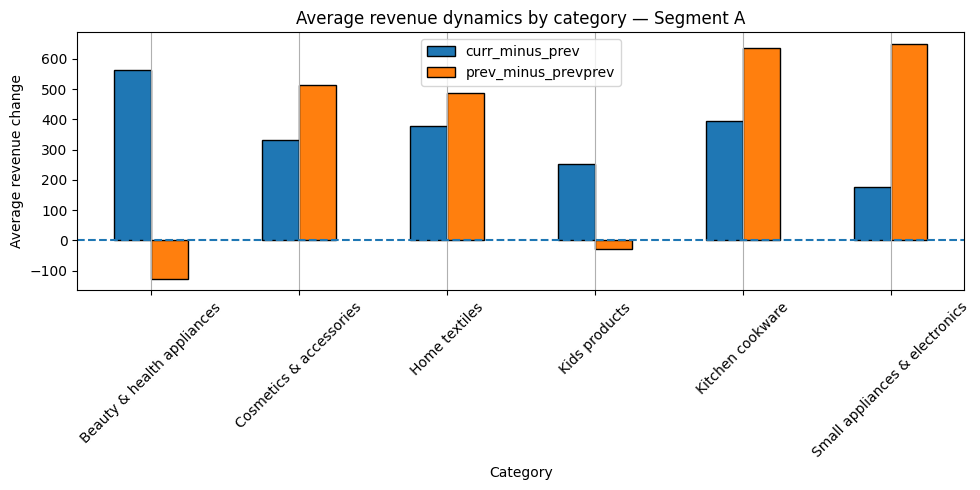


Segment B: Average revenue dynamics by category


,curr_minus_prev,prev_minus_prevprev
popular_category,,
Beauty & health appliances,343.29,-40.33
Cosmetics & accessories,233.89,548.07
Home textiles,263.47,239.62
Kids products,323.79,-38.94
Kitchen cookware,293.70,701.31
Small appliances & electronics,195.58,126.00


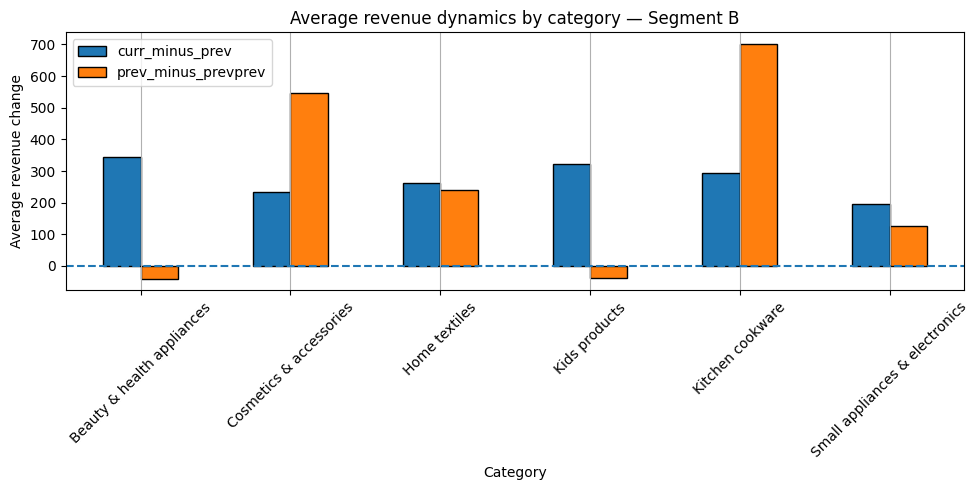


Segment C: Average revenue dynamics by category


,curr_minus_prev,prev_minus_prevprev
popular_category,,
Kids products,295.34,-3.03


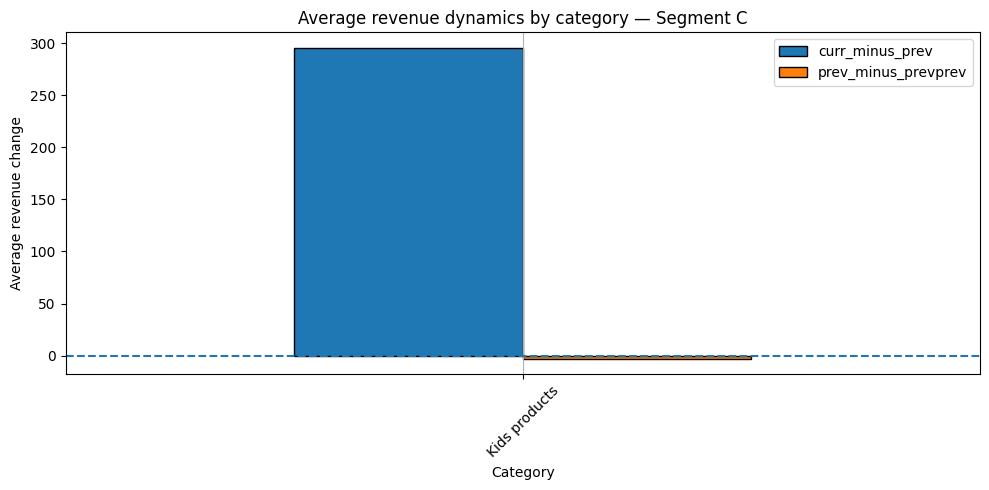

In [225]:
# 1. Add revenue columns from df_full to each segment
cols_to_add = ['customer_id', 'popular_category', 'revenue_prev_prev', 'revenue_prev', 'revenue_current']

segment_A_ext = segment_A.merge(df_full[cols_to_add], on=['customer_id', 'popular_category'], how='left')
segment_B_ext = segment_B.merge(df_full[cols_to_add], on=['customer_id', 'popular_category'], how='left')
segment_C_ext = segment_C.merge(df_full[cols_to_add], on=['customer_id', 'popular_category'], how='left')

# 2. Compute deltas
for df in [segment_A_ext, segment_B_ext, segment_C_ext]:
    df['curr_minus_prev'] = df['revenue_current'] - df['revenue_prev']
    df['prev_minus_prevprev'] = df['revenue_prev'] - df['revenue_prev_prev']

# 3. Function: print and plot
def revenue_dynamics_summary_with_plot(df_segment, name):
    summary = df_segment.groupby('popular_category')[['curr_minus_prev', 'prev_minus_prevprev']].mean().round(2)
    print(f"\n{name}: Average revenue dynamics by category")
    display(summary)

    # Plot
    summary.plot(kind='bar', figsize=(10, 5), edgecolor='black')
    plt.title(f'Average revenue dynamics by category — {name}')
    plt.xlabel('Category')
    plt.ylabel('Average revenue change')
    plt.axhline(0, linestyle='--')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 4. Apply to each segment
revenue_dynamics_summary_with_plot(segment_A_ext, "Segment A")
revenue_dynamics_summary_with_plot(segment_B_ext, "Segment B")
revenue_dynamics_summary_with_plot(segment_C_ext, "Segment C")


### Step 8 Conclusion: Customer Segmentation & Recommendations

**Selected segment:**
Analysis is focused on **Segment A** — customers with **high profit (> 4.0)** and **high churn probability (> 0.7)**.
This segment includes **245 customers** (over 12% of the base) and contributes disproportionately to revenue.

**Revenue dynamics:**
- The strongest month-over-month growth (current vs. previous) is in **Cosmetics & accessories**, **Kitchen cookware**, and **Home textiles**.
- A decline in the **penultimate** month (previous vs. prev-prev) is seen in **Beauty & health appliances** and **Kids products**, signaling a possible drop in interest for these categories.
- Despite growth in the current month, **Kids products** show weak stability — revenue fluctuates.

**Recommended actions:**
- Launch personalized newsletters centered on each customer’s preferred categories.
- Split customers by promo sensitivity:
  - offer value propositions **without** discounts to one subgroup,
  - use **discounts/bonuses/cashback** for the price-sensitive subgroup.
- Add perks for the most profitable clients: priority support, dedicated manager line, early access to new products.

**Business rationale:**
- Losing a customer from this segment can cost **4–7 units of profit**.
- Retaining even **10%** of this segment can materially increase **LTV** and reduce **CAC**.
- Segment A customers show clear preferences, enabling precise targeting and personalization.

**Bottom line:**
**Segment A** warrants **top priority** due to its high profit, notable churn risk, and strong retention upside. Personalization and offer optimization should help keep these customers and lift their lifetime value.


### Overall Project Summary

#### Task
The online store “One Click” set the task to predict the probability of a **decrease in customer activity** among existing customers in order to identify **risk groups** and propose **personalized retention actions**.

---

#### Data and Sources
Four tables were provided:
- `market_file.csv` — marketing, behavioral, and categorical features.
- `market_money.csv` — monthly revenue.
- `market_time.csv` — time spent on the site.
- `money.csv` — total profit per customer.

---

#### Data Preprocessing
- Fixed typos in categorical features and period names.
- Checked and cleaned duplicates and missing values.
- Excluded **3 customers** with zero revenue in at least one month.
- Filtered one extreme revenue outlier.
- Tables were merged by `customer_id`; the final dataset contains **1300 rows** and **18 features**.

---

#### Exploratory Data Analysis (EDA)
- Customers with decreased activity tend to:
  - opt in to notifications less often,
  - spend less time on the site,
  - view fewer pages and categories and make fewer purchases,
  - rely more on promotions,
  - generate lower revenue.
- Correlations confirm: engagement (time, views, pages) is negatively associated with churn risk.
- Features with the most outliers: marketing activity and promo purchases.
- These features were retained as potentially informative.

---

#### Model Training
- Trained 4 models (`LogisticRegression`, `DecisionTree`, `KNeighbors`, `SVC`) with two scaling options (`StandardScaler`, `MinMaxScaler`).
- Used `RandomizedSearchCV`; primary metric — **ROC AUC**.
- **Best model:** `KNeighborsClassifier`, ROC AUC = **0.9129**.
- Also strong:
  - `LogisticRegression` — **0.9123**
  - `SVC` — **0.9009**

---

#### Model Interpretation
- For interpretability, used `LogisticRegression`.
- SHAP highlights the strongest drivers of churn risk:
  - `pages_per_visit`, `avg_categories_per_visit` — engagement indicators (higher engagement → lower risk).
  - `unpaid_products_qtr`, `promo_purchases` — abandoned carts and promo sensitivity increase risk.
  - `marketing_activity_6m` and earlier revenues — signs of marketing fatigue at high levels.

---

#### Customer Segmentation

Based on churn probability, profit, and behavior, **three segments** were identified:

- **Segment A** — **245 customers**: high profit (> 4.0) and high churn risk (> 0.7).
  - *Avg. profit:* 4.76
  - *Avg. churn probability:* 0.95
  - *Popular categories:* Kids products, Cosmetics & accessories, Home textiles
  - *Negative dynamics:* Beauty & health appliances (drop in the penultimate month)

- **Segment B** — **80 customers**: high share of promo purchases (> 0.7), medium profit (2–4).
  - Risk of discount dependency.
  - Revenue declines in several categories, notably Kids products.

- **Segment C** — **140 customers**: buyers of **Kids products** with elevated churn risk (> 0.5).
  - Unstable revenue; possible category issues (assortment freshness, UX, seasonality).

---

#### Revenue Dynamics
- **Segment A:** strongest decline in **Beauty & health appliances** (previous vs. prev-prev month).
- **Segment B:** negative dynamics in **Kids products** and partially in appliances.
- **Segment C:** **Kids products** show weak stability with a drop in the penultimate month.

---

#### Business Recommendations

**Segment A — priority retention**
- Personalize marketing by preferred categories.
- Add perks for top-profit clients: loyalty bonuses, priority support, exclusive offers.
- Avoid broad discounts — retain via service quality and privileges.

**Segment B — control discount dependency**
- Run A/B tests to reduce promo frequency.
- Offer alternatives: cashback, tiered points, loyalty perks.

**Segment C — category review**
- Conduct UX/usability review for the site journey.
- Reassess **Kids products** assortment and seasonality.
- Collect customer feedback to uncover reasons for declining interest.


### Commentary on Recommendations

**Segment A — priority retention**
**Why selected:**
These customers have **high profit** and **high churn probability**. Losing them would be the most painful for the business, so retaining this group is the top priority.

**Recommendations:**

- **Personalized offers:**
  Keep purchase interest high with targeted campaigns in preferred categories (e.g., **Kids products**, **Cosmetics & accessories**, etc.) to raise engagement **without** lowering prices.

- **Loyalty perks / priority service:**
  Since this segment is profitable, strengthen emotional attachment via non-price benefits: priority delivery, early access to new collections, dedicated manager.

- **Avoid discounts:**
  These customers already buy at full price and are **not** promotion-driven; discounts would be inefficient and erode margin.

---

**Segment B — controlling discount dependency**
**Why selected:**
These customers buy heavily on promotions while delivering only **medium** profit. There’s a risk they’ve become discount-dependent and won’t purchase without promos.

**Recommendations:**

- **A/B test on limiting discounts:**
  Test their reaction to reduced/no promotions. If they keep buying, margin improves.

- **Shift to alternative value:**
  Replace constant discounts with cashback, tiered points, or recommendation-based offers. This reduces promo dependency and teaches a different value proposition.

---

**Segment C — category and UX analysis**
**Why selected:**
These customers primarily buy **Kids products** and show **elevated churn risk**. Analysis shows negative revenue dynamics specifically in this category.

**Recommendations:**

- **Assortment review:**
  The assortment may be outdated or mismatched with expectations. Reassess and refresh where needed.

- **Collect feedback:**
  Run a focused survey/interviews for this group to learn why interest is dropping.

- **UX and storefront audit:**
  Issues may stem from presentation rather than product: filters, descriptions, photos, positioning. Verify UX before investing in inventory chan
